#### This models what occurs in the systems, from a starting point of the drug being injected subcutaneously and how it behaves from there — the AD part of ADME.

# Imports and useful functions

In [35]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 8})


## Define parameters

In [28]:
# "Finalized" or "ultimate" parameters
k_ABS = 1  # Absorption rate constant DONE
k_CP = 0.01  # Rate constant from central to peripheral compartment DONE
k_PC = 0.01  # Rate constant from peripheral to central compartment DONE
k_Celim = 0.001  # Elimination rate constant (30 day half-life) DONE
k_CT = 0.01  # Rate constant for tumor homing DONE
k_TC = 0.001  # Rate constant for leaving the tumor compartment DONE
k_CL = 0.001  # Rate constant for accumulation in the liver DONE
k_TMEelim = 0.00001  # TME effects reducing persistence in the tumor DONE

V_CENTRAL = 3.0  # Volume of central compartment [Liters], plasma in blood
V_TUMOR = 0.1  # Volume of tumor compartment [Liters], average size of a large tumor (100 cm^3)
dose = 450 # or 300 # Initial dose [10^6 cells]
AVOGADRO = 6.022e23  # Avogadro's number [molecules/mol]

dose_moles = dose / AVOGADRO

In [4]:
parameter_sweep = {
    'k_ABS': 1, # If IV injection, dose is immediately available in the central compartment.
    'k_CP': np.logspace(-6, -1, 6), # [1/hour] Wide range of values
    'k_PC': np.logspace(-6, -1, 6), # [1/hour]
    'k_Celim': 0.001, # [1/hour]
    'k_CT': np.logspace(-6, -1, 6), # [1/hour] Depending on efficacy of design
    'k_TC': np.logspace(-3, -1, 6), # [1/hour] Depends on tumor's ability to retain drug
    'k_CL': np.logspace(-6, -1, 6), # [1/hour] Cachectic patients might suffer from higher levels of trafficking into the liver
    'k_TMEelim': 0.00001, # [1/min] TME effects reducing persistence in the tumor
    'dose': [20, 70, 140, 200, 300, 450], # [10^6 of cells, determined for a 70 kg individual]
}

## Define the model

In [5]:
# Define the multi-compartment model with biodistribution and TME effects
def pk_model(y, t, k_ABS, k_CP, k_PC, k_Celim, k_CT, k_TC, k_CL, k_TMEelim):
    dAdt = -k_ABS * y[0]  # Dosing compartment
    dCdt = (k_ABS * y[0] / V_CENTRAL) - (k_CP + k_CT + k_CL + k_Celim) * y[1] \
           + k_PC * y[2] + k_TC * y[3]  # Central compartment
    dPdt = k_CP * y[1] - k_PC * y[2]  # Peripheral compartment
    dTdt = k_CT * y[1] - (k_TC + k_TMEelim) * (y[3])  # Tumor compartment
    dLiverdt = k_CL * y[1]  # Liver compartment (accumulation only)
    return [dAdt, dCdt, dPdt, dTdt, dLiverdt]

## Simulation and solving the ODE

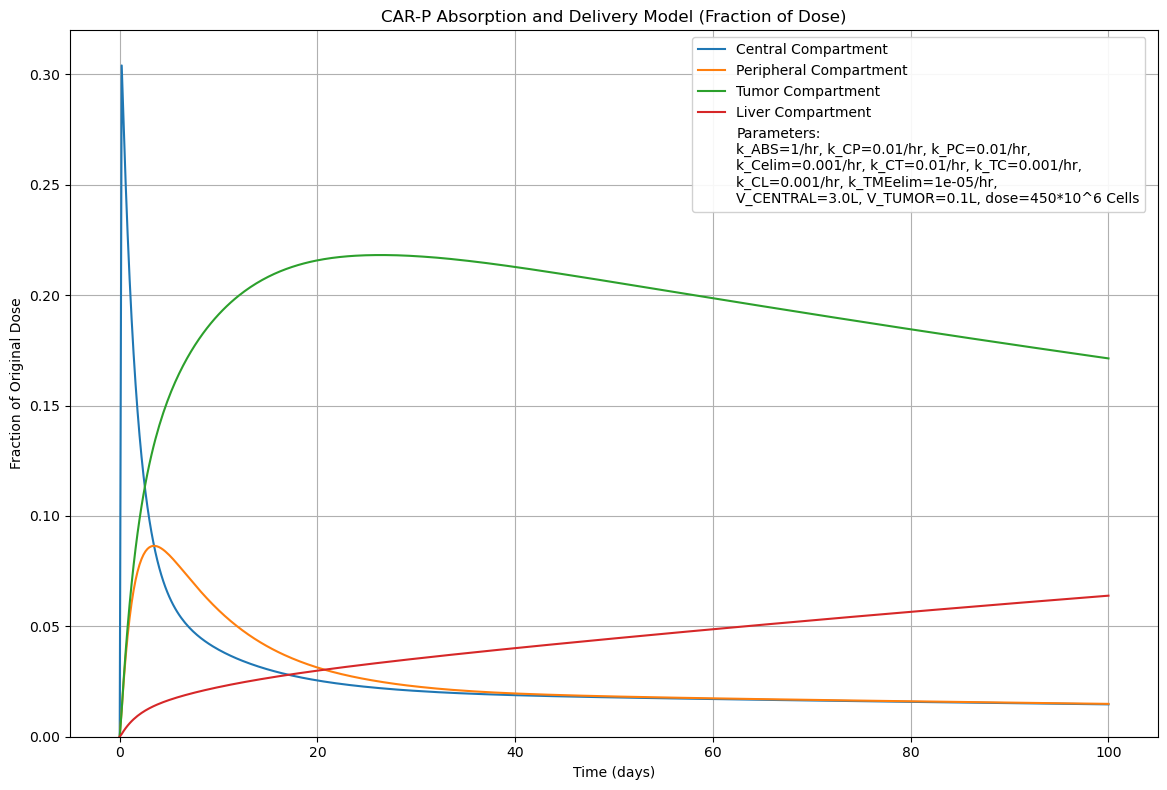

In [29]:
# Time points for simulation
t = np.linspace(0, 2400, 500)  # Simulate over 48 hours with fine resolution
t_days = t / 24

# Initial conditions: [Dosing Compartment [mol], Central Compartment [mol], Peripheral Compartment [mol], Tumor Compartment [mol], Liver Compartment [mol]]
y0_updated = [dose_moles, 0, 0, 0, 0]

# Solver options for increased precision
solver_options = {'atol': 1e-25, 'rtol': 1e-9} # Adjust tolerances as needed

# Solve ODE for the updated model
solution_updated = odeint(pk_model, y0_updated, t,
                          args=(k_ABS, k_CP, k_PC, k_Celim, k_CT, k_TC,
                                k_CL, k_TMEelim), **solver_options)

# Calculate the fraction of the original dose for each compartment
fraction_dose_central = solution_updated[:, 1] / dose_moles  # Central compartment
fraction_dose_peripheral = solution_updated[:, 2] / dose_moles  # Peripheral compartment
fraction_dose_tumor = solution_updated[:, 3] / dose_moles  # Tumor compartment
fraction_dose_liver = solution_updated[:, 4] / dose_moles  # Liver compartment

# Plot results in DAYS
plt.figure(figsize=(12, 8))
plt.plot(t_days, fraction_dose_central, label='Central Compartment')
plt.plot(t_days, fraction_dose_peripheral, label='Peripheral Compartment')
plt.plot(t_days, fraction_dose_tumor, label='Tumor Compartment')
plt.plot(t_days, fraction_dose_liver, label='Liver Compartment')

# Add parameters to the legend
parameters_text = (
    f"k_ABS={k_ABS}/hr, k_CP={k_CP}/hr, k_PC={k_PC}/hr,\n" 
    f"k_Celim={k_Celim}/hr, k_CT={k_CT}/hr, k_TC={k_TC}/hr,\n"
    f"k_CL={k_CL}/hr, k_TMEelim={k_TMEelim}/hr,\n"
    f"V_CENTRAL={V_CENTRAL}L, V_TUMOR={V_TUMOR}L, dose={dose}*10^6 Cells"
)
plt.plot([], [], ' ', label=f"Parameters:\n{parameters_text}")

# Add labels and title
plt.xlabel('Time (days)')
plt.ylabel('Fraction of Original Dose')
plt.title('CAR-P Absorption and Delivery Model (Fraction of Dose)')

# Add legend on top of the plot
plt.legend(loc='upper center', bbox_to_anchor=(0.78, 1), frameon=True, framealpha=0.9, ncol=1)  # Adjust position and transparency
plt.ylim((0.00, 0.32))
plt.grid(True)
plt.tight_layout()
plt.show()

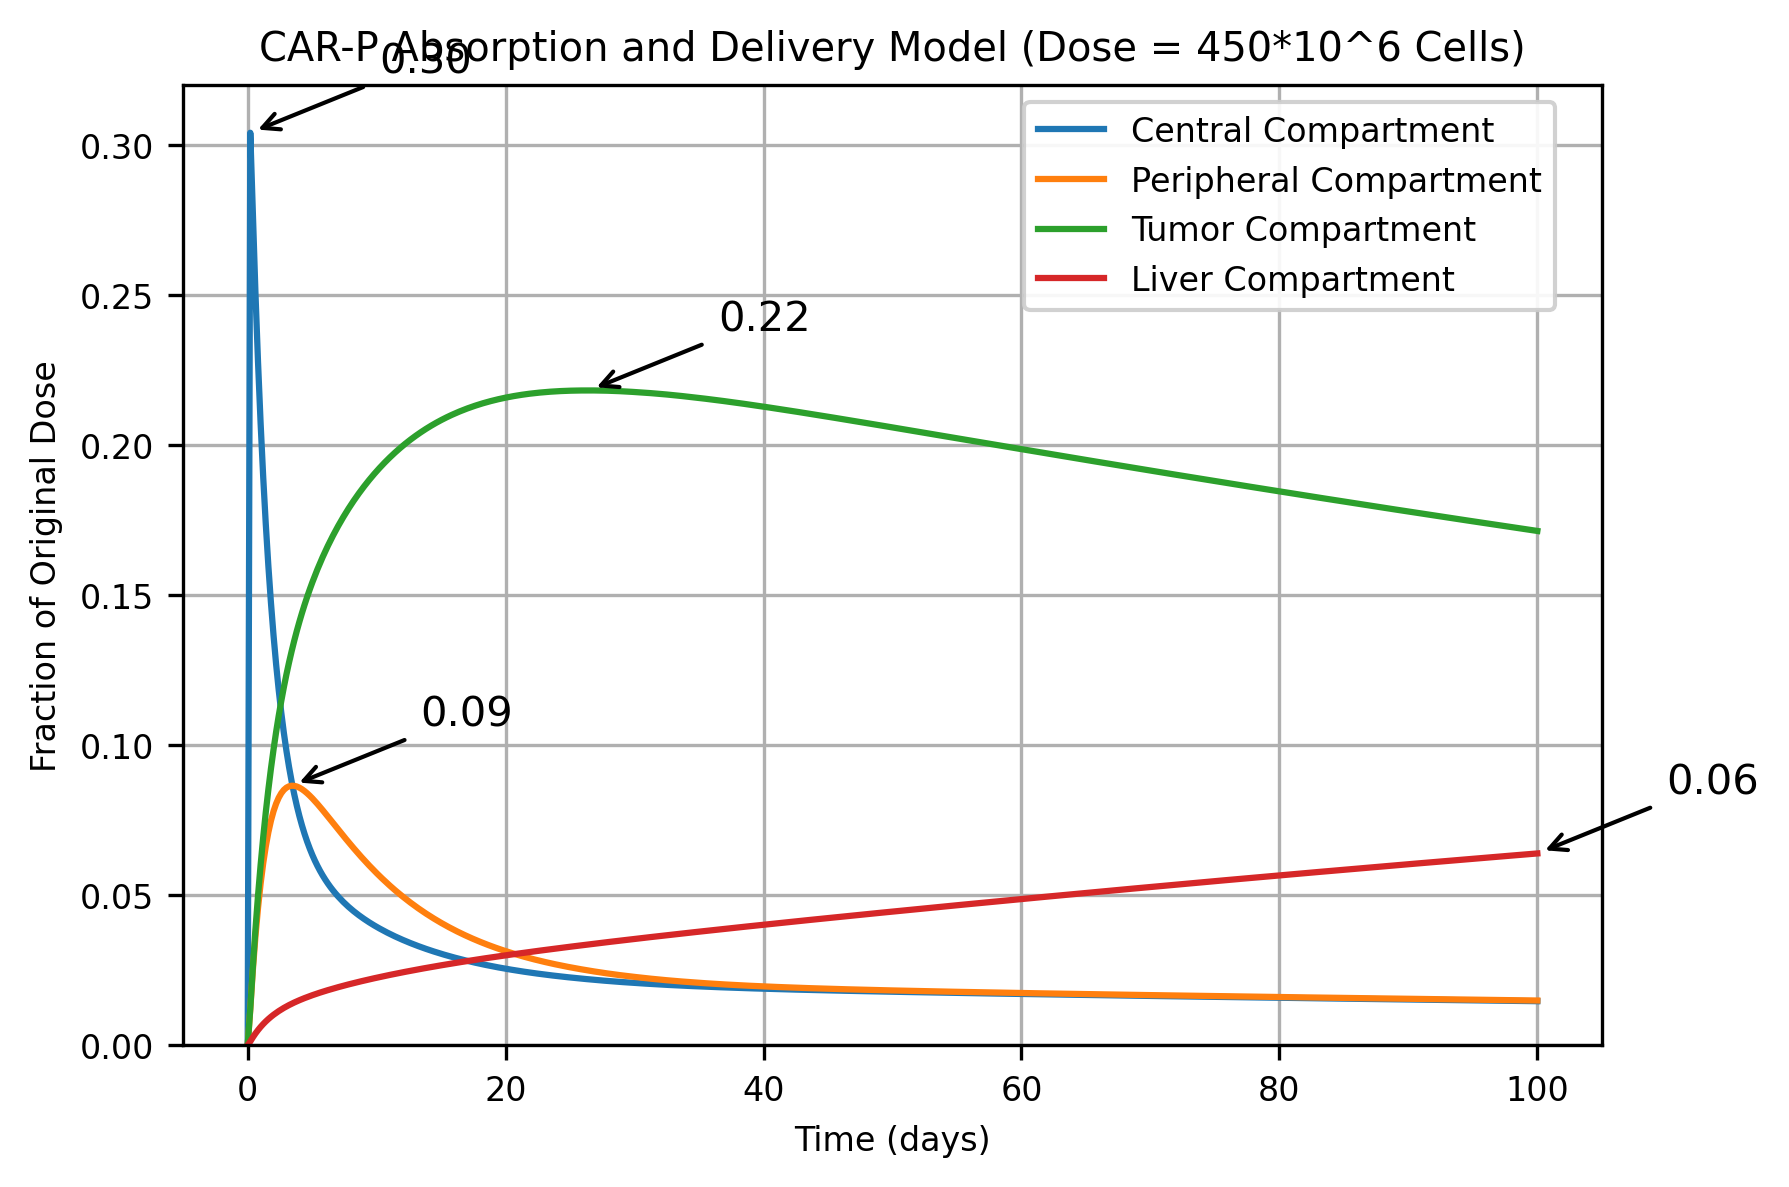

k_ABS=1/hr, k_CP=0.01/hr, k_PC=0.01/hr,
k_Celim=0.001/hr, k_CT=0.01/hr, k_TC=0.001/hr,
k_CL=0.001/hr, k_TMEelim=1e-05/hr,
V_CENTRAL=3.0L, V_TUMOR=0.1L, dose=450*10^6 Cells


In [47]:
# ANNOTATING PEAK VALUES
# Calculate the peak values and their corresponding times
peak_central = np.max(fraction_dose_central)
time_peak_central = t_days[np.argmax(fraction_dose_central)]

peak_peripheral = np.max(fraction_dose_peripheral)
time_peak_peripheral = t_days[np.argmax(fraction_dose_peripheral)]

peak_tumor = np.max(fraction_dose_tumor)
time_peak_tumor = t_days[np.argmax(fraction_dose_tumor)]

peak_liver = np.max(fraction_dose_liver)
time_peak_liver = t_days[np.argmax(fraction_dose_liver)]

# Plot results in DAYS
plt.figure(figsize=(6, 4), dpi=300)
# plt.figure(figsize=(7.09, 3.5), dpi=300)
plt.plot(t_days, fraction_dose_central, label='Central Compartment')
plt.plot(t_days, fraction_dose_peripheral, label='Peripheral Compartment')
plt.plot(t_days, fraction_dose_tumor, label='Tumor Compartment')
plt.plot(t_days, fraction_dose_liver, label='Liver Compartment')

# Annotate the peaks
plt.annotate(f'{peak_central:.2f}', xy=(time_peak_central, peak_central), 
             xytext=(time_peak_central + 10, peak_central + 0.02),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=10)
plt.annotate(f'{peak_peripheral:.2f}', xy=(time_peak_peripheral, peak_peripheral), 
             xytext=(time_peak_peripheral + 10, peak_peripheral + 0.02),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=10)
plt.annotate(f'{peak_tumor:.2f}', xy=(time_peak_tumor, peak_tumor), 
             xytext=(time_peak_tumor + 10, peak_tumor + 0.02),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=10)
plt.annotate(f'{peak_liver:.2f}', xy=(time_peak_liver, peak_liver), 
             xytext=(time_peak_liver + 10, peak_liver + 0.02),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=10)

# # Add parameters to the legend
parameters_text = (
    f"k_ABS={k_ABS}/hr, k_CP={k_CP}/hr, k_PC={k_PC}/hr,\n" 
    f"k_Celim={k_Celim}/hr, k_CT={k_CT}/hr, k_TC={k_TC}/hr,\n"
    f"k_CL={k_CL}/hr, k_TMEelim={k_TMEelim}/hr,\n"
    f"V_CENTRAL={V_CENTRAL}L, V_TUMOR={V_TUMOR}L, dose={dose}*10^6 Cells"
)
# plt.plot([], [], ' ', label=f"Parameters:\n{parameters_text}")

# Add labels and title
plt.xlabel('Time (days)')
plt.ylabel('Fraction of Original Dose')
plt.title('CAR-P Absorption and Delivery Model (Dose = 450*10^6 Cells)')

# Add legend on top of the plot
plt.legend(loc='upper center', bbox_to_anchor=(0.78, 1), frameon=True, framealpha=0.9, ncol=1)  # Adjust position and transparency
plt.ylim((0.00, 0.32))
plt.grid(True)
plt.tight_layout()
plt.savefig('CARP_100days.jpg', format='jpeg', dpi=300)

plt.show()
print(parameters_text)

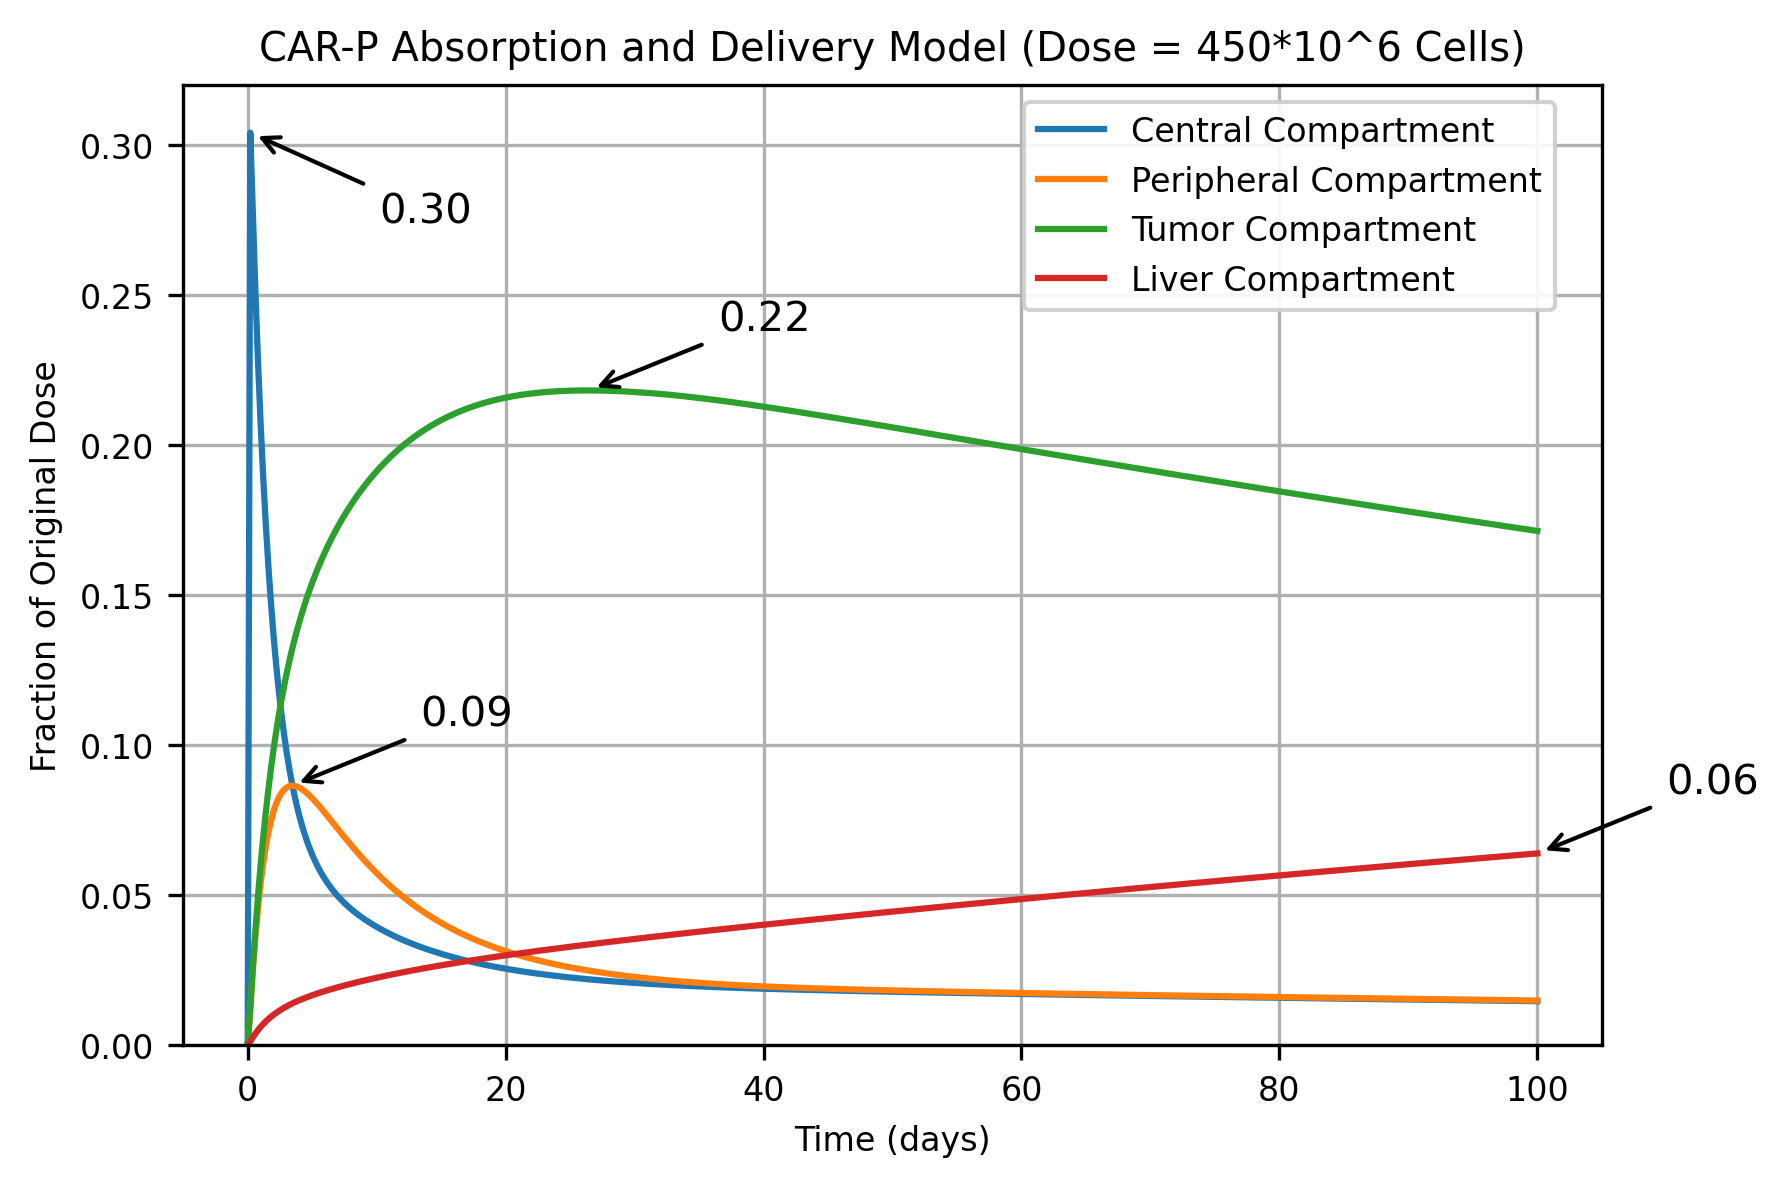

k_ABS=1/hr, k_CP=0.01/hr, k_PC=0.01/hr,
k_Celim=0.001/hr, k_CT=0.01/hr, k_TC=0.001/hr,
k_CL=0.001/hr, k_TMEelim=1e-05/hr,
V_CENTRAL=3.0L, V_TUMOR=0.1L, dose=450*10^6 Cells


In [ ]:
# ANNOTATING PEAK VALUES
# Calculate the peak values and their corresponding times
peak_central = np.max(fraction_dose_central)
time_peak_central = t_days[np.argmax(fraction_dose_central)]

peak_peripheral = np.max(fraction_dose_peripheral)
time_peak_peripheral = t_days[np.argmax(fraction_dose_peripheral)]

peak_tumor = np.max(fraction_dose_tumor)
time_peak_tumor = t_days[np.argmax(fraction_dose_tumor)]

peak_liver = np.max(fraction_dose_liver)
time_peak_liver = t_days[np.argmax(fraction_dose_liver)]

# Plot results in DAYS
plt.figure(figsize=(6, 4), dpi=300)
plt.plot(t_days, fraction_dose_central, label='Central Compartment')
plt.plot(t_days, fraction_dose_peripheral, label='Peripheral Compartment')
plt.plot(t_days, fraction_dose_tumor, label='Tumor Compartment')
plt.plot(t_days, fraction_dose_liver, label='Liver Compartment')

# Annotate the peaks with adjusted positions
# Central Compartment
plt.annotate(f'{peak_central:.2f}', xy=(time_peak_central, peak_central), 
             xytext=(time_peak_central + 10, peak_central - 0.03),  # Adjusted downward to avoid title overlap
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=10)

# Peripheral Compartment
plt.annotate(f'{peak_peripheral:.2f}', xy=(time_peak_peripheral, peak_peripheral), 
             xytext=(time_peak_peripheral + 10, peak_peripheral + 0.02),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=10)

# Tumor Compartment
plt.annotate(f'{peak_tumor:.2f}', xy=(time_peak_tumor, peak_tumor), 
             xytext=(time_peak_tumor + 10, peak_tumor + 0.02),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=10)

# Liver Compartment
plt.annotate(f'{peak_liver:.2f}', xy=(time_peak_liver, peak_liver), 
             xytext=(time_peak_liver + 10, peak_liver + 0.02),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=10)

# Add labels and title
plt.xlabel('Time (days)')
plt.ylabel('Fraction of Original Dose')
plt.title('CAR-P Absorption and Delivery Model (Dose = 450*10^6 Cells)')

# Add legend on top of the plot
plt.legend(loc='upper center', bbox_to_anchor=(0.78, 1), frameon=True, framealpha=0.9, ncol=1)  # Adjust position and transparency
plt.ylim((0.00, 0.32))
plt.grid(True)
plt.tight_layout()
plt.savefig('Systems/April6_Plots/CARP_100days.jpg', format='jpeg', dpi=300)

plt.show()
print(parameters_text)

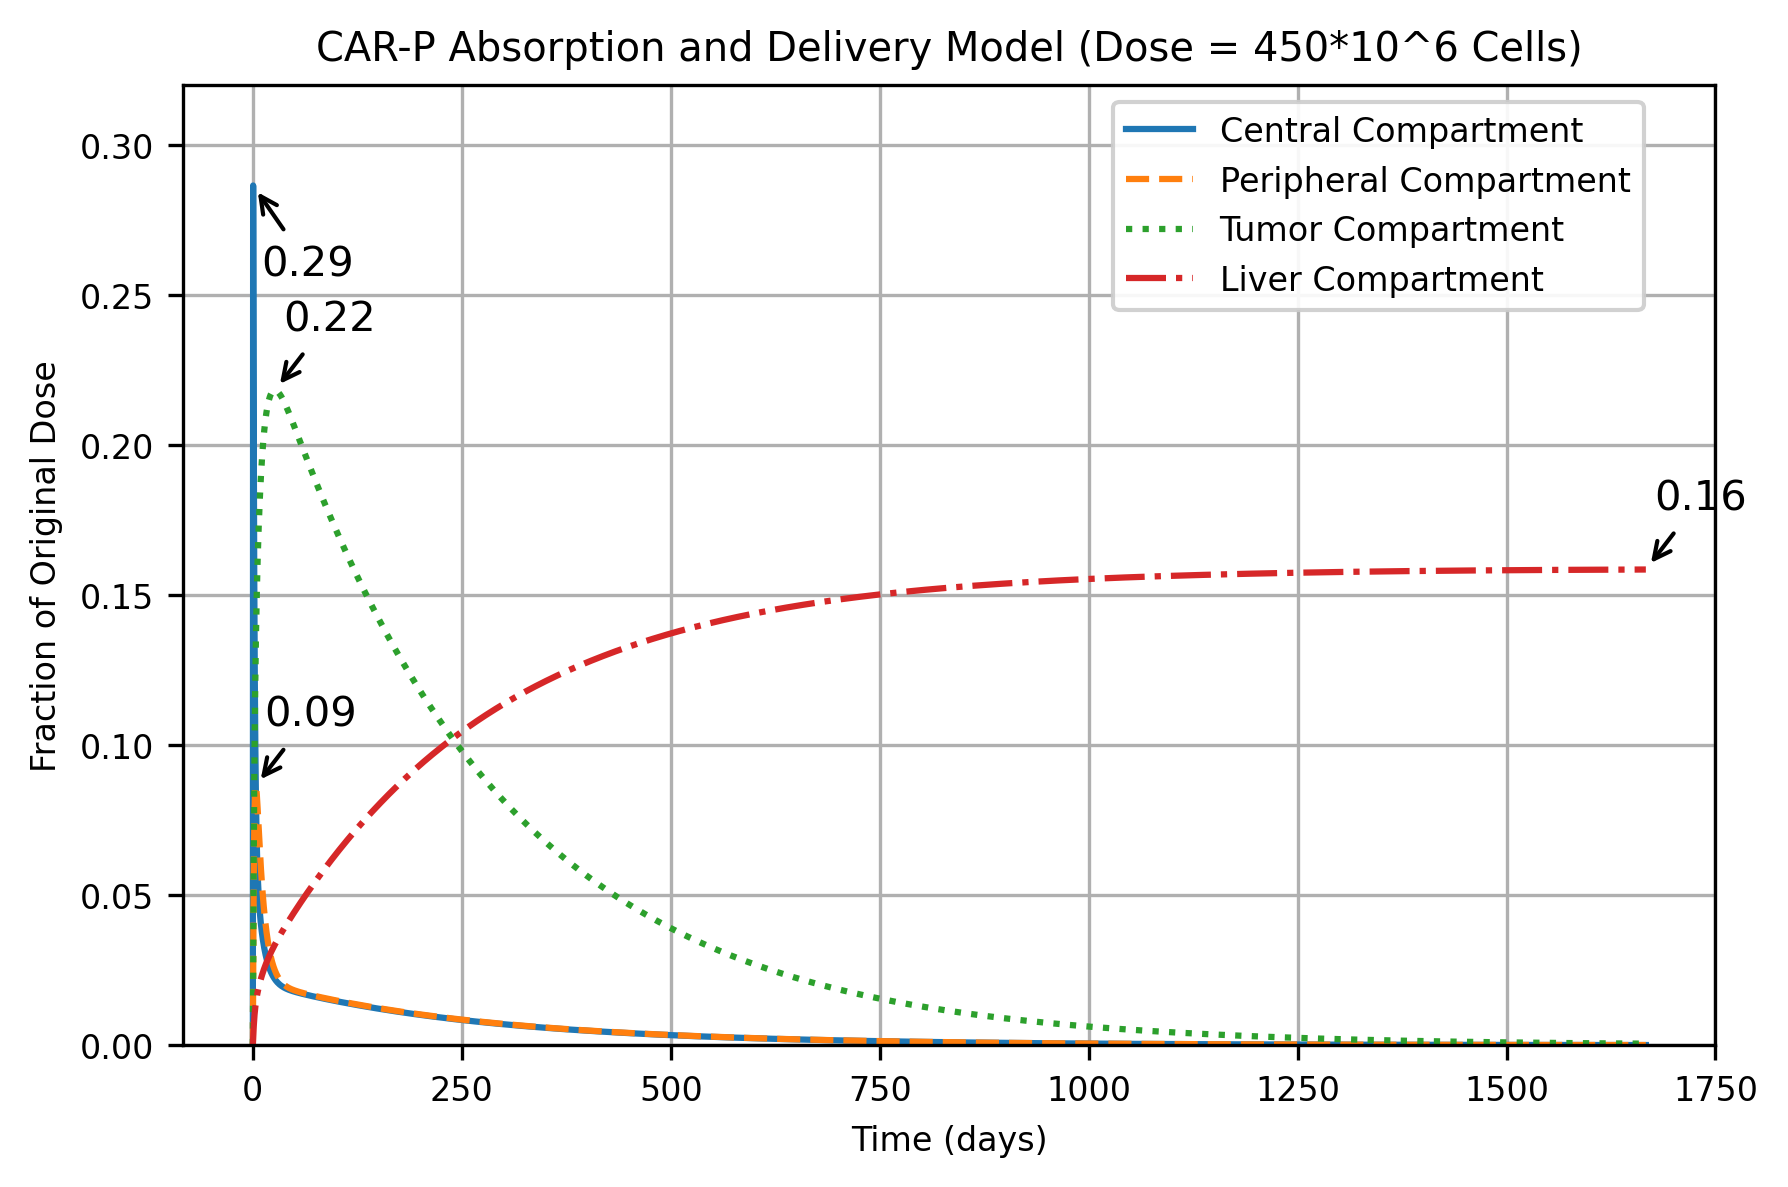

k_ABS=1/hr, k_CP=0.01/hr, k_PC=0.01/hr,
k_Celim=0.001/hr, k_CT=0.01/hr, k_TC=0.001/hr,
k_CL=0.001/hr, k_TMEelim=1e-05/hr,
V_CENTRAL=3.0L, V_TUMOR=0.1L, dose=450*10^6 Cells


In [52]:
# Time points for simulation
t = np.linspace(0, 40000, 5000)  # Simulate over 48 hours with fine resolution
t_days = t / 24

# Initial conditions: [Dosing Compartment [mol], Central Compartment [mol], Peripheral Compartment [mol], Tumor Compartment [mol], Liver Compartment [mol]]
y0_updated = [dose_moles, 0, 0, 0, 0]

# Solver options for increased precision
solver_options = {'atol': 1e-25, 'rtol': 1e-9} # Adjust tolerances as needed

# Solve ODE for the updated model
solution_updated = odeint(pk_model, y0_updated, t,
                          args=(k_ABS, k_CP, k_PC, k_Celim, k_CT, k_TC,
                                k_CL, k_TMEelim), **solver_options)

# Calculate the fraction of the original dose for each compartment
fraction_dose_central = solution_updated[:, 1] / dose_moles  # Central compartment
fraction_dose_peripheral = solution_updated[:, 2] / dose_moles  # Peripheral compartment
fraction_dose_tumor = solution_updated[:, 3] / dose_moles  # Tumor compartment
fraction_dose_liver = solution_updated[:, 4] / dose_moles  # Liver compartment

# ANNOTATING PEAK VALUES
# Calculate the peak values and their corresponding times
peak_central = np.max(fraction_dose_central)
time_peak_central = t_days[np.argmax(fraction_dose_central)]

peak_peripheral = np.max(fraction_dose_peripheral)
time_peak_peripheral = t_days[np.argmax(fraction_dose_peripheral)]

peak_tumor = np.max(fraction_dose_tumor)
time_peak_tumor = t_days[np.argmax(fraction_dose_tumor)]

peak_liver = np.max(fraction_dose_liver)
time_peak_liver = t_days[np.argmax(fraction_dose_liver)]

# Plot results in DAYS
plt.figure(figsize=(6, 4), dpi=300)
plt.plot(t_days, fraction_dose_central, label='Central Compartment', linestyle='solid')
plt.plot(t_days, fraction_dose_peripheral, label='Peripheral Compartment', linestyle='dashed')
plt.plot(t_days, fraction_dose_tumor, label='Tumor Compartment', linestyle='dotted')
plt.plot(t_days, fraction_dose_liver, label='Liver Compartment', linestyle='dashdot')

# Annotate the peaks with adjusted positions
# Central Compartment
plt.annotate(f'{peak_central:.2f}', xy=(time_peak_central, peak_central), 
             xytext=(time_peak_central + 10, peak_central - 0.03),  # Adjusted downward to avoid title overlap
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=10)

# Peripheral Compartment
plt.annotate(f'{peak_peripheral:.2f}', xy=(time_peak_peripheral, peak_peripheral), 
             xytext=(time_peak_peripheral + 10, peak_peripheral + 0.02),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=10)

# Tumor Compartment
plt.annotate(f'{peak_tumor:.2f}', xy=(time_peak_tumor, peak_tumor), 
             xytext=(time_peak_tumor + 10, peak_tumor + 0.02),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=10)

# Liver Compartment
plt.annotate(f'{peak_liver:.2f}', xy=(time_peak_liver, peak_liver), 
             xytext=(time_peak_liver + 10, peak_liver + 0.02),
             arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=10)

# Add labels and title
plt.xlabel('Time (days)')
plt.ylabel('Fraction of Original Dose')
plt.title('CAR-P Absorption and Delivery Model (Dose = 450*10^6 Cells)')

# Add legend on top of the plot
plt.legend(loc='upper center', bbox_to_anchor=(0.78, 1), frameon=True, framealpha=0.9, ncol=1)  # Adjust position and transparency
plt.ylim((0.00, 0.32))
plt.grid(True)
plt.tight_layout()
plt.savefig('Systems/April6_Plots/CARP_1700days.jpg', format='jpeg', dpi=300)

plt.show()
print(parameters_text)

In [51]:
max_tumor_index = np.argmax(solution_updated[:,3])
time_of_max_tumor = t[max_tumor_index] # in hours
max_tumor_concentration = solution_updated[max_tumor_index, 3]

print(f"Time of Maximum Tumor Concentration: {time_of_max_tumor:.2f} hours")
print(f"Time of Maximum Tumor Concentration: {time_of_max_tumor/24:.2f} days")

print(f"Maximum Tumor Concentration: {max_tumor_concentration:.2e} Molar")

Time of Maximum Tumor Concentration: 632.13 hours
Time of Maximum Tumor Concentration: 26.34 days
Maximum Tumor Concentration: 1.63e-22 Molar


## Parameter sweep

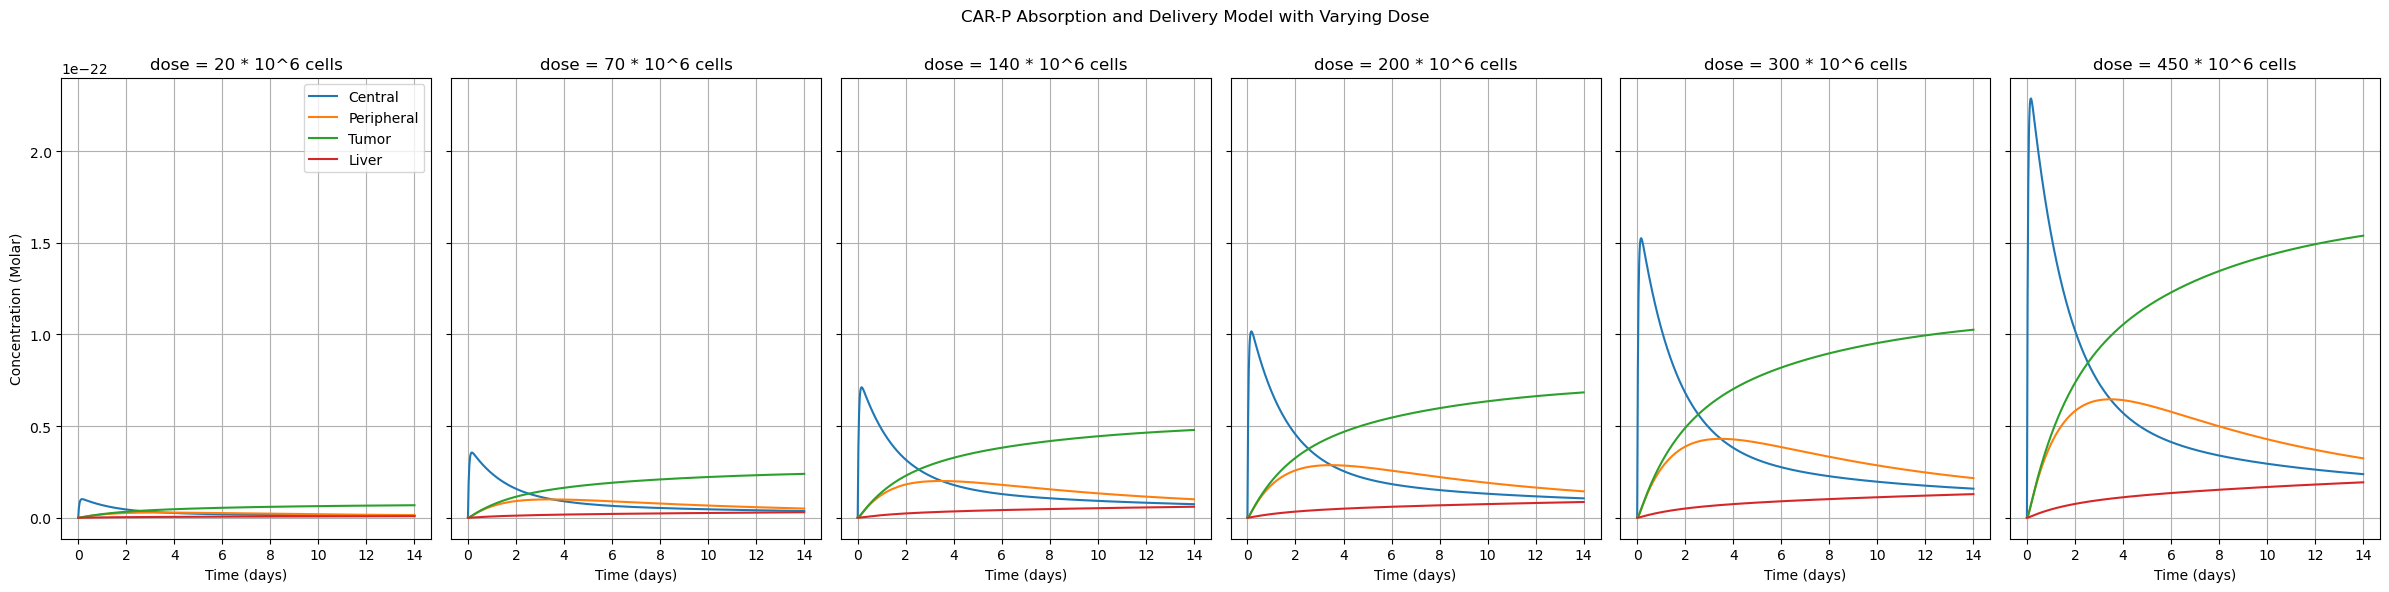

In [150]:
# EVERYTIME YOU SWITCH, CHANGE IN 5 SPOTS

# Time points for simulation
t = np.linspace(0, 336, 1000)  # Simulate over 48 hours with fine resolution
t_days = t / 24

# Initial conditions: [Dosing Compartment, Central Compartment, Peripheral Compartment,
# Tumor Compartment, Liver Compartment, Lung Compartment]
# y0_updated = [dose_moles, 0, 0, 0, 0]

# Solver options for increased precision
solver_options = {'atol': 1e-25, 'rtol': 1e-9} # Adjust tolerances as needed

variable = 'Dose'
num_sweeps = len(parameter_sweep['dose'])
fig, axes = plt.subplots(1, num_sweeps, figsize=(num_sweeps * 4, 6), sharey=True)

for i, rate_constant in enumerate(parameter_sweep['dose']):
    # Solve ODE for the updated model
    # Initial conditions: [Dosing Compartment, Central Compartment, Peripheral Compartment,
    # Tumor Compartment, Liver Compartment, Lung Compartment]
    y0_updated = [rate_constant/AVOGADRO, 0, 0, 0, 0]

    solution_updated = odeint(pk_model, y0_updated, t,
                          args=(k_ABS, k_CP, k_PC, k_Celim, k_CT, k_TC,
                                k_CL, k_TMEelim), **solver_options)

    ax = axes[i] if num_sweeps > 1 else axes
    ax.plot(t_days, solution_updated[:, 1], label='Central')
    ax.plot(t_days, solution_updated[:, 2], label='Peripheral')
    ax.plot(t_days, solution_updated[:, 3], label='Tumor')
    ax.plot(t_days, solution_updated[:, 4], label='Liver')

    ax.set_xlabel('Time (days)')
    # ax.set_title(f'k_CL = {rate_constant:.1e}')
    ax.set_title(f'dose = {rate_constant} * 10^6 cells')
    ax.grid(True)

axes[0].set_ylabel('Concentration (Molar)')
axes[0].legend()

plt.suptitle(f'CAR-P Absorption and Delivery Model with Varying {variable}')
plt.tight_layout()
plt.show()

## Efficacy analysis

AUC in Tumor Compartment: 7.82e-19
Efficacy Threshold Met: Yes


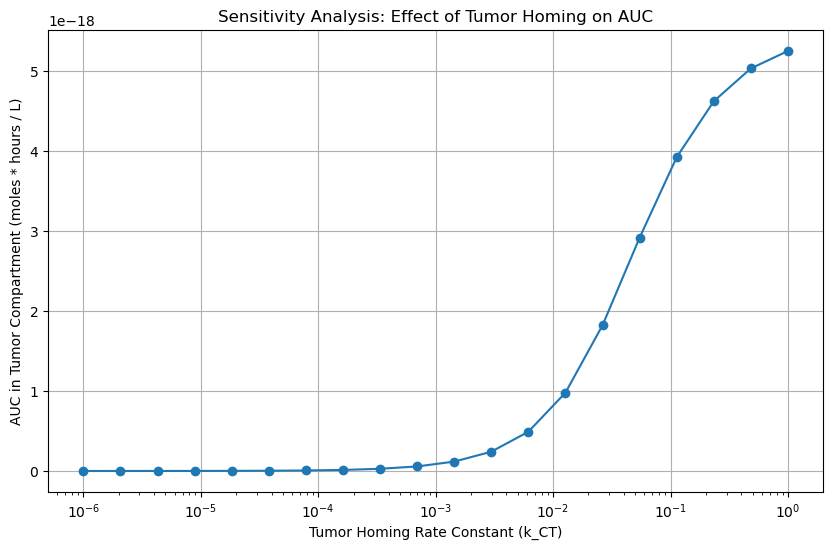

In [8]:
# Quantify Tumor Penetration and Efficacy

# Define efficacy threshold for tumor compartment concentration
efficacy_threshold = 10^-20

# Calculate Area Under the Curve (AUC) for tumor compartment
def calculate_auc(concentration, time):
    return np.trapz(concentration, time)

auc_tumor = calculate_auc(solution_updated[:, 3], t)

# Check if efficacy threshold is met
efficacy_met = np.max(solution_updated[:, 3]) >= efficacy_threshold

print(f"AUC in Tumor Compartment: {auc_tumor:.2e}")
print(f"Efficacy Threshold Met: {'Yes' if efficacy_met else 'No'}")

# Sensitivity Analysis

# Define a function to run the model and calculate AUC for tumor compartment
def run_model_and_calculate_auc(k_tumor_val):
    solution_updated = odeint(pk_model, y0_updated, t,
                          args=(k_ABS, k_CP, k_PC, k_Celim, k_tumor_val, k_TC,
                                k_CL, k_TMEelim), **solver_options)
    auc_sa = calculate_auc(solution_updated[:, 3], t)
    return auc_sa

# Perform sensitivity analysis on tumor homing parameter (k_tumor)
k_tumor_values = np.logspace(-6, 0, 20)   # Test values for sensitivity analysis
auc_results = [run_model_and_calculate_auc(k) for k in k_tumor_values]

# Plot sensitivity analysis results
plt.figure(figsize=(10, 6))
plt.semilogx(k_tumor_values, auc_results, marker='o', linestyle='-')
plt.xlabel('Tumor Homing Rate Constant (k_CT)')
plt.ylabel('AUC in Tumor Compartment (moles * hours / L)')
plt.title('Sensitivity Analysis: Effect of Tumor Homing on AUC')
plt.grid(True, which="major", ls="-")
plt.show()

Calculate AUC0-28d and AUC0-70d for short- and long- term AUC

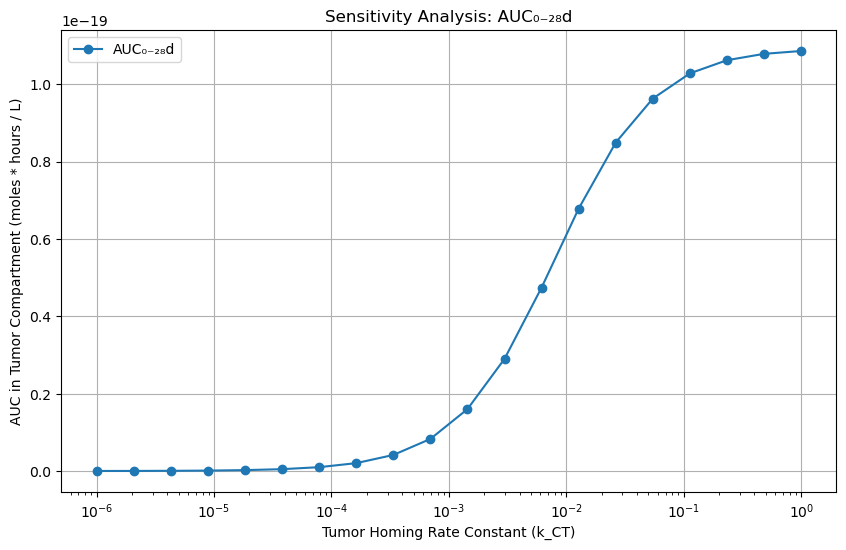

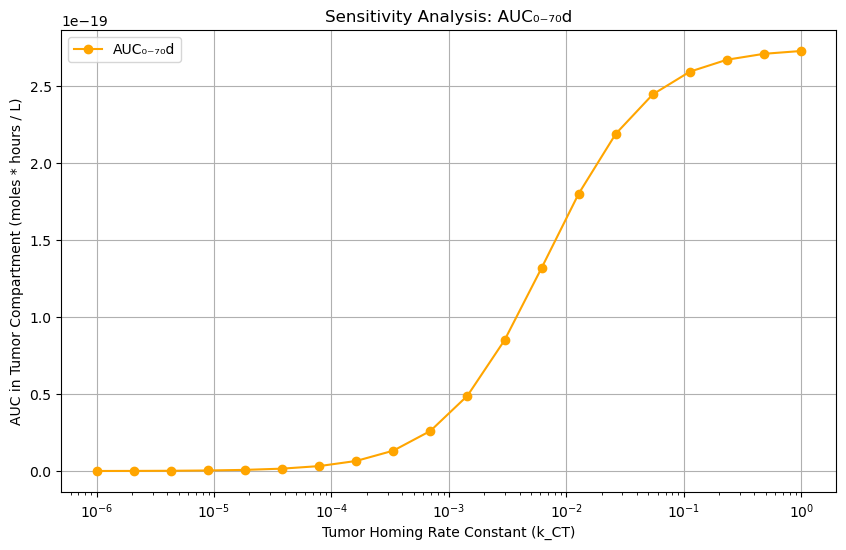

In [9]:
# Define a function to calculate AUC for a specific time range
def calculate_auc_in_range(concentration, time, start_day, end_day):
    """
    Calculate the AUC for a specific time range.

    Parameters:
    - concentration: Array of concentrations (e.g., tumor compartment).
    - time: Array of time points (in hours).
    - start_day: Start of the time range (in days).
    - end_day: End of the time range (in days).

    Returns:
    - AUC for the specified time range.
    """
    start_time = start_day * 24  # Convert days to hours
    end_time = end_day * 24      # Convert days to hours

    # Find indices corresponding to the time range
    indices = (time >= start_time) & (time <= end_time)

    # Calculate AUC using trapezoidal rule
    return np.trapz(concentration[indices], time[indices])

# Calculate AUC₀₋₂₈d and AUC₀₋₇₀d for sensitivity analysis
auc_28d_results = [calculate_auc_in_range(odeint(pk_model, y0_updated, t,
                          args=(k_ABS, k_CP, k_PC, k_Celim, k, k_TC,
                                k_CL, k_TMEelim), **solver_options)[:, 3], t, 0, 28) for k in k_tumor_values]

auc_70d_results = [calculate_auc_in_range(odeint(pk_model, y0_updated, t,
                          args=(k_ABS, k_CP, k_PC, k_Celim, k, k_TC,
                                k_CL, k_TMEelim), **solver_options)[:, 3], t, 0, 70) for k in k_tumor_values]

# Plot AUC₀₋₂₈d
plt.figure(figsize=(10, 6))
plt.semilogx(k_tumor_values, auc_28d_results, marker='o', linestyle='-', label='AUC₀₋₂₈d')
plt.xlabel('Tumor Homing Rate Constant (k_CT)')
plt.ylabel('AUC in Tumor Compartment (moles * hours / L)')
plt.title('Sensitivity Analysis: AUC₀₋₂₈d')
plt.grid(True, which="major", ls="-")
plt.legend()
plt.show()

# Plot AUC₀₋₇₀d
plt.figure(figsize=(10, 6))
plt.semilogx(k_tumor_values, auc_70d_results, marker='o', linestyle='-', label='AUC₀₋₇₀d', color='orange')
plt.xlabel('Tumor Homing Rate Constant (k_CT)')
plt.ylabel('AUC in Tumor Compartment (moles * hours / L)')
plt.title('Sensitivity Analysis: AUC₀₋₇₀d')
plt.grid(True, which="major", ls="-")
plt.legend()
plt.show()

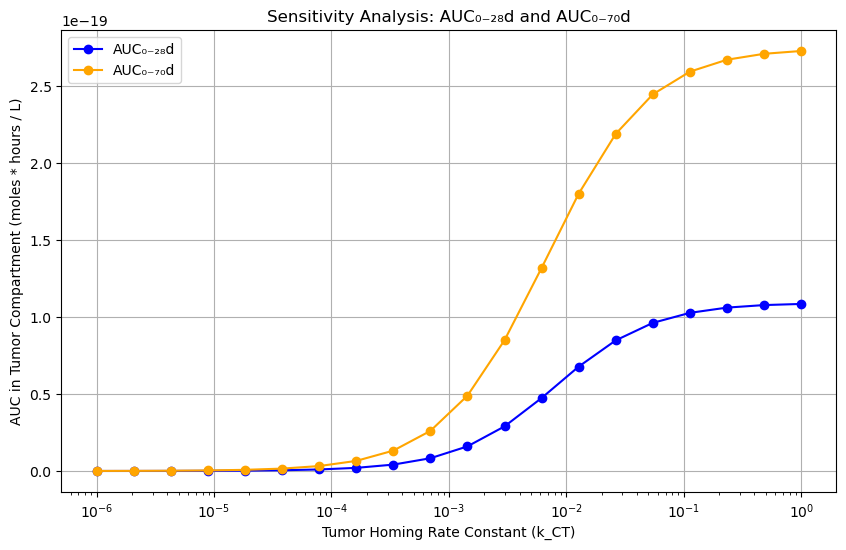

In [12]:
# Plot AUC₀₋₂₈d and AUC₀₋₇₀d on the same plot
plt.figure(figsize=(10, 6))

# Plot AUC₀₋₂₈d
plt.semilogx(k_tumor_values, auc_28d_results, marker='o', linestyle='-', label='AUC₀₋₂₈d', color='blue')

# Plot AUC₀₋₇₀d
plt.semilogx(k_tumor_values, auc_70d_results, marker='o', linestyle='-', label='AUC₀₋₇₀d', color='orange')

# Add labels, title, and legend
plt.xlabel('Tumor Homing Rate Constant (k_CT)')
plt.ylabel('AUC in Tumor Compartment (moles * hours / L)')
plt.title('Sensitivity Analysis: AUC₀₋₂₈d and AUC₀₋₇₀d')
plt.grid(True, which="major", ls="-")
plt.legend()
plt.show()

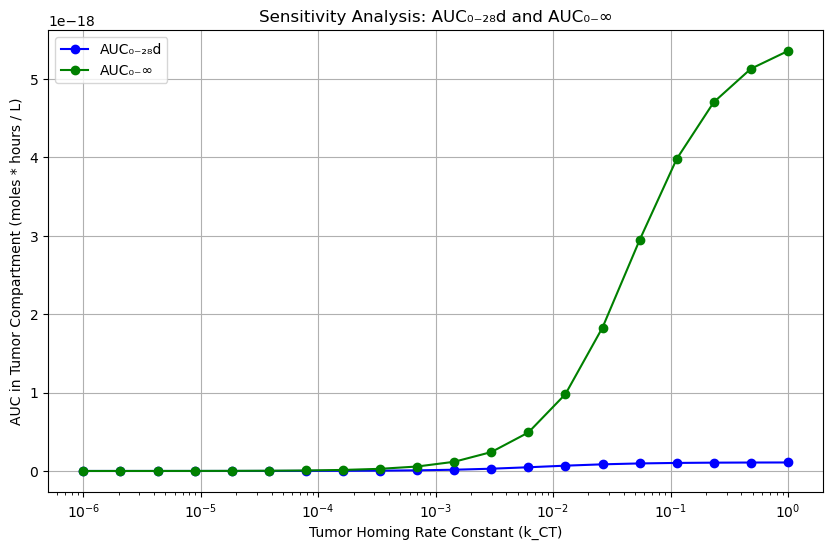

In [13]:
# Define a function to calculate AUC from 0 to infinity
def calculate_auc_0_inf(concentration, time, k_Celim):
    """
    Calculate the AUC from 0 to infinity.

    Parameters:
    - concentration: Array of concentrations (e.g., tumor compartment).
    - time: Array of time points (in hours).
    - k_Celim: Elimination rate constant (1/hour).

    Returns:
    - AUC from 0 to infinity.
    """
    # AUC for the simulated time range (0 to max time)
    auc_simulated = np.trapz(concentration, time)

    # Estimate the remaining AUC beyond the simulation time
    c_last = concentration[-1]  # Last concentration value
    t_last = time[-1]           # Last time point
    auc_remaining = c_last / k_Celim if k_Celim > 0 else 0  # Exponential decay assumption

    # Total AUC (simulated + remaining)
    return auc_simulated + auc_remaining

# Calculate AUC₀₋₂₈d and AUC₀₋∞ for sensitivity analysis
auc_inf_results = [calculate_auc_0_inf(odeint(pk_model, y0_updated, t,
                          args=(k_ABS, k_CP, k_PC, k_Celim, k, k_TC,
                                k_CL, k_TMEelim), **solver_options)[:, 3], t, k_Celim) for k in k_tumor_values]

# Plot AUC₀₋₂₈d and AUC₀₋∞ on the same plot
plt.figure(figsize=(10, 6))

# Plot AUC₀₋₂₈d
plt.semilogx(k_tumor_values, auc_28d_results, marker='o', linestyle='-', label='AUC₀₋₂₈d', color='blue')

# Plot AUC₀₋∞
plt.semilogx(k_tumor_values, auc_inf_results, marker='o', linestyle='-', label='AUC₀₋∞', color='green')

# Add labels, title, and legend
plt.xlabel('Tumor Homing Rate Constant (k_CT)')
plt.ylabel('AUC in Tumor Compartment (moles * hours / L)')
plt.title('Sensitivity Analysis: AUC₀₋₂₈d and AUC₀₋∞')
plt.grid(True, which="major", ls="-")
plt.legend()
plt.show()

# Sensitivity analysis

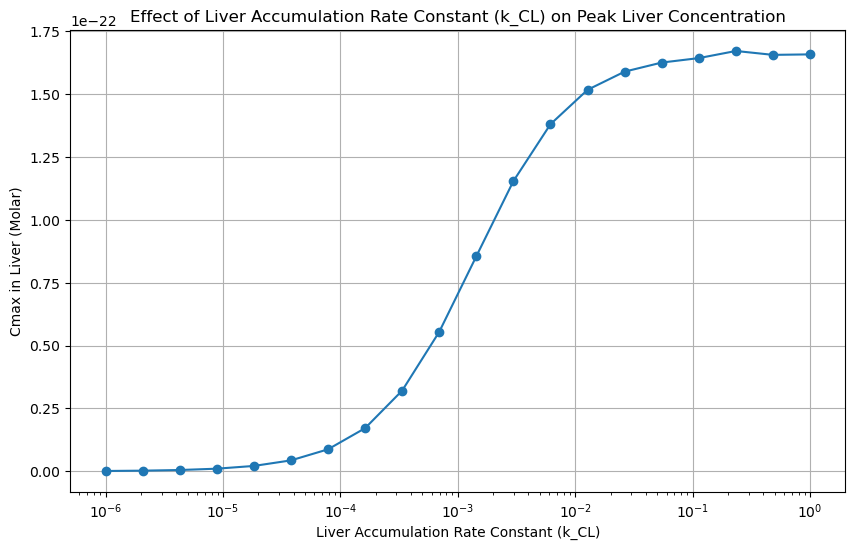

In [ ]:
# Define a function to calculate the peak liver concentration (Cmax in liver compartment) for a given k_CL
def calculate_peak_liver_concentration(k_CL):
    solution = odeint(pk_model, y0_updated, t,
                      args=(k_ABS, k_CP, k_PC, k_Celim, k_CT, k_TC,
                            k_CL, k_TMEelim))
    peak_liver_concentration = np.max(solution[:, 4])  # Liver compartment is index 4
    return peak_liver_concentration

# Perform the analysis for varying k_a values
k_CL_values = np.logspace(-6, 0, num=20)  # Use 'k_ABS' for absorption rate constant
peak_liver_concentrations = [calculate_peak_liver_concentration(k) for k in k_CL_values]

# Plot the results
plt.figure(figsize=(10, 6))
plt.semilogx(k_CL_values, peak_liver_concentrations, marker='o', linestyle='-')
plt.xlabel('Liver Accumulation Rate Constant (k_CL)')
plt.ylabel('Cmax in Liver (Molar)')
plt.title('Effect of Liver Accumulation Rate Constant (k_CL) on Cmax in Liver')
plt.grid(True)
plt.show()

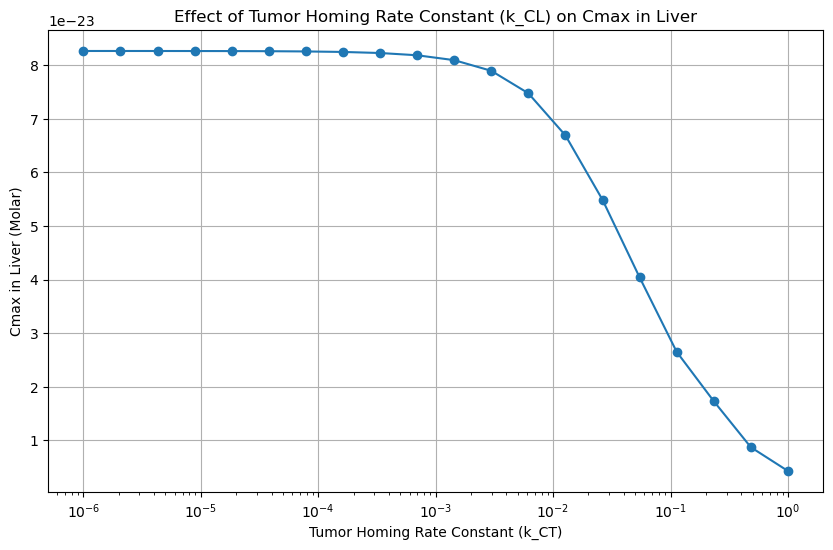

In [15]:
# Define a function to calculate the peak LIVER concentration (Cmax in central compartment) for a given k_CT
def calculate_peak_liver_concentration(k_CT):
    solution = odeint(pk_model, y0_updated, t,
                      args=(k_ABS, k_CP, k_PC, k_Celim, k_CT, k_TC,
                            k_CL, k_TMEelim))
    peak_liver_concentration = np.max(solution[:, 4])  # Liver compartment is index 4
    return peak_liver_concentration

# Perform the analysis for varying k_CT values
k_CT_values = np.logspace(-6, 0, num=20) 
peak_liver_concentrations = [calculate_peak_liver_concentration(k) for k in k_CT_values]

# Plot the results
plt.figure(figsize=(10, 6))
plt.semilogx(k_CT_values, peak_liver_concentrations, marker='o', linestyle='-')
plt.xlabel('Tumor Homing Rate Constant (k_CT)')
plt.ylabel('Cmax in Liver (Molar)')
plt.title('Effect of Tumor Homing Rate Constant (k_CL) on Cmax in Liver')
plt.grid(True)
plt.show()

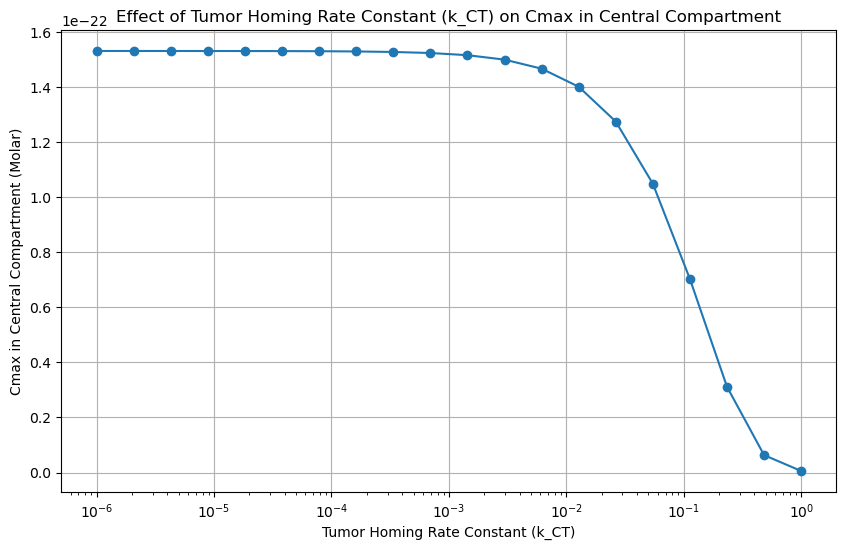

In [17]:
# Define a function to calculate the peak "blood" (central compartment) concentration (Cmax in central compartment) for a given k_CT
def calculate_peak_blood_concentration(k_CT):
    solution = odeint(pk_model, y0_updated, t,
                      args=(k_ABS, k_CP, k_PC, k_Celim, k_CT, k_TC,
                            k_CL, k_TMEelim))
    peak_blood_concentration = np.max(solution[:, 1])  # Central compartment is index 1
    return peak_blood_concentration

# Perform the analysis for varying k_a values
k_CT_values = np.logspace(-6, 0, num=20)  # Use 'k_ABS' for absorption rate constant
peak_blood_concentrations = [calculate_peak_blood_concentration(k) for k in k_CT_values]

# Plot the results
plt.figure(figsize=(10, 6))
plt.semilogx(k_CT_values, peak_blood_concentrations, marker='o', linestyle='-')
plt.xlabel('Tumor Homing Rate Constant (k_CT)')
plt.ylabel('Cmax in Central Compartment (Molar)')
plt.title('Effect of Tumor Homing Rate Constant (k_CT) on Cmax in Central Compartment')
plt.grid(True)
plt.show()

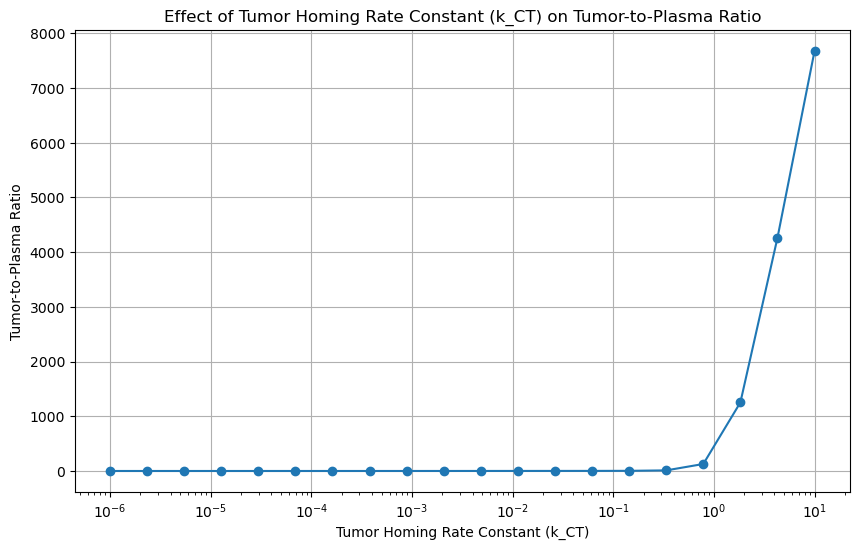

In [190]:
# Define a function to calculate the tumor-to-plasma ratio for a given k_CT
def calculate_tumor_plasma_ratio(k_CT_value):
    solution = odeint(pk_model, y0_updated, t,
                      args=(k_ABS, k_CP, k_PC, k_Celim, k_CT_value, k_TC,
                            k_CL, k_TMEelim))
    # Initial conditions: [Dosing Compartment, Central Compartment, Peripheral Compartment,
    # Tumor Compartment, Liver Compartment]
    peak_tumor_concentration = np.max(solution[:, 3])  # Tumor compartment is index 3
    peak_plasma_concentration = np.max(solution[:, 1])  # Central compartment is index 1
    return peak_tumor_concentration / peak_plasma_concentration

# Perform the analysis for varying k_CT values
k_CT_values = np.logspace(-6, 1, num=20)  # Use 'k_ABS' for absorption rate constant
tumor_plasma_ratios = [calculate_tumor_plasma_ratio(k) for k in k_CT_values]

# Plot the results
plt.figure(figsize=(10, 6))
plt.semilogx(k_CT_values, tumor_plasma_ratios, marker='o', linestyle='-')
plt.xlabel('Tumor Homing Rate Constant (k_CT)')
plt.ylabel('Tumor-to-Plasma Ratio')
plt.title('Effect of Tumor Homing Rate Constant (k_CT) on Tumor-to-Plasma Ratio')
plt.grid(True)
plt.show()

In [ ]:
# Define a function to calculate the therapeutic index
def calculate_therapeutic_index(mtc, mec):
    """
    Calculate the therapeutic index (TI) as the ratio of MTC to MEC.

    Parameters:
    - mtc: Minimum Toxic Concentration (Molar)
    - mec: Minimum Effective Concentration (Molar)

    Returns:
    - Therapeutic Index (TI)
    """
    if mec == 0:
        raise ValueError("MEC cannot be zero.")
    return mtc / mec

# Example values for MTC and MEC (in Molar)
mtc = 1e-5  # Example: 10 µM COMES FROM JEANNIE'S ANALYSIS
mec = 1e-7  # Example: 0.1 µM COMES FROM KATIE'S ANALYSIS

# Calculate the therapeutic index
therapeutic_index = calculate_therapeutic_index(mtc, mec)
print(f"Therapeutic Index (TI): {therapeutic_index:.2f}")
# A higher TI indicates a safer drug, while a lower TI indivates a narrow safety margin